In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.daf.butler as dafButler
import lsst.geom as geom
from astropy.visualization import ZScaleInterval

%run -n -i "subtraction_defs.py"

In [2]:
REPO = '/data1/gkovacs/ci_hsc_gen3/DATA'
butler = dafButler.Butler(REPO)

In [5]:
butler.collections

CollectionSearch(())

In [36]:
# PCA repo
REPO = '/data1/ci_hsgkovacs/DM-27128-repo3/ingested/rerun/pccd2'
# PSFEX repo
# REPO = '/data1/gkovacs/DM-27127-repo/ingested/rerun/pccd_psfex'

butler = dafPersist.Butler(REPO)
# butler.queryMetadata('src',['visit', 'ccdnum', 'filter'], dataId = {'visit': 419802})
dataId={'visit': 419802, 'ccdnum':25}

In [43]:
calexp.getInfo().getVisitInfo()

In [53]:
butler.queryMetadata('deepCoadd_sub',[ 'filter', 'tract', 'patch'], dataId = {'filter':'r', 'tract': 0})

TypeError: querySubClosure() missing 1 required positional argument: 'dataId'

In [47]:
skyMap = butler.get("deepCoadd_skyMap")

In [48]:
butler.dataRef

<bound method Butler.dataRef of Butler(datasetTypeAliasDict={}, repos=RepoDataContainer(_inputs=[RepoData(id=139814705259472,repoArgs=RepositoryArgs(root='/data1/gkovacs/DM-27128-repo3/ingested/rerun/pccd2', cfgRoot=None, mapper=None, mapperArgs=None, tags=set(), mode='rw', policy=None)cfg=RepositoryCfg(root='/data1/gkovacs/DM-27128-repo3/ingested/rerun/pccd2', mapper=<class 'lsst.obs.decam.decamMapper.DecamMapper'>, mapperArgs={'calibRoot': '/data1/gkovacs/DM-27128-repo3/calibingested'}, parents=['../..'], policy=None),cfgOrigin=existing,cfgRoot=/data1/gkovacs/DM-27128-repo3/ingested/rerun/pccd2,repo=<lsst.daf.persistence.repository.Repository object at 0x7f292676a250>,parentRepoDatas=[139814705261136],isV1Repository=False,role=output,parentRegistry=<lsst.daf.persistence.registries.SqliteRegistry object at 0x7f2925cd5910>), RepoData(id=139814705261136,repoArgs=RepositoryArgs(root='/data1/gkovacs/DM-27128-repo3/ingested', cfgRoot='/data1/gkovacs/DM-27128-repo3/ingested', mapper=None, m

In [7]:
calexp = butler.get('calexp', dataId=dataId)
srcCat = butler.get('src', dataId=dataId)

In [9]:
expWcs = calexp.getWcs()
expBoxD = geom.Box2D(calexp.getBBox())
#expBoxD.grow(self.config.templateBorderSize)
ctrSkyPos = expWcs.pixelToSky(expBoxD.getCenter())

In [14]:
tractInfo = skyMap.findTract(ctrSkyPos)
patchList = tractInfo.findPatchList([ctrSkyPos,])
patchInfo = patchList[0]

In [73]:
patchArgDict = dict(
    datasetType="deepCoadd_sub",
    bbox=patchInfo.getOuterBBox(),
    tract=tractInfo.getId(),
    patch="%s,%s" % (patchInfo.getIndex()[0], patchInfo.getIndex()[1]),
    subfilter=0,
    numSubfilters=0,
    filter='g'
    )

In [74]:
patchArgDict

{'datasetType': 'deepCoadd_sub',
 'bbox': Box2I(minimum=Point2I(71900, 31900), dimensions=Extent2I(4200, 4200)),
 'tract': 0,
 'patch': '18,8',
 'subfilter': 0,
 'numSubfilters': 0,
 'filter': 'g'}

In [75]:
butler.datasetExists(**patchArgDict)

True

In [78]:
coaddexp = butler.get(**patchArgDict)

In [81]:
coaddexp.getPsf()

In [4]:
#print(srcCat.columns.schema)

In [5]:
i_goodSrc = np.flatnonzero(srcCat['calib_psf_used'])  # indices of the good sources

<IPython.core.display.Javascript object>


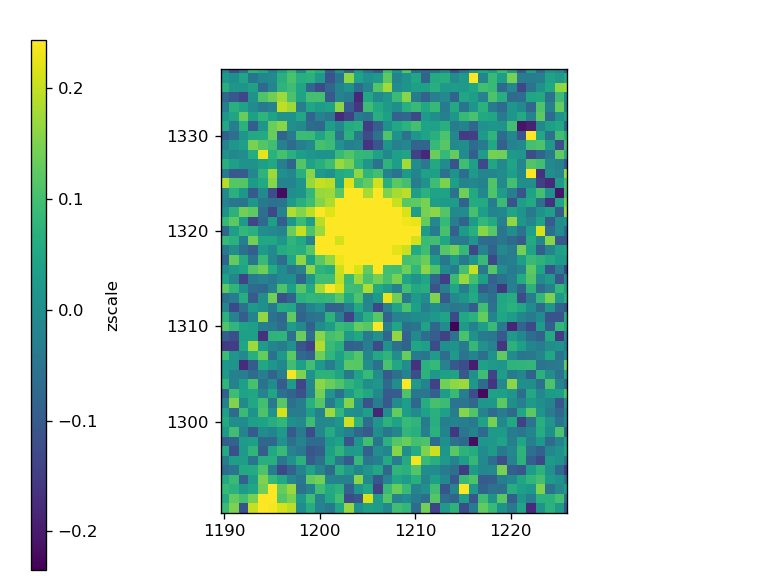

In [80]:
# Show the image with the centroids of the selected sources
zScaler = ZScaleInterval()
vmin, vmax = zScaler.get_limits(coaddexp.image.array)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
cb = ax.imshow(coaddexp.image.array, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax)
# ax.scatter(srcCat['base_NaiveCentroid_x'][i_goodSrc], srcCat['base_NaiveCentroid_y'][i_goodSrc],
#            marker='+', color='red')
# ax.scatter(srcCat['base_SdssCentroid_x'][i_goodSrc], srcCat['base_SdssCentroid_y'][i_goodSrc],
#            marker='x', color='cyan')
# ax.set_title("Selected sources in the image")
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax, label='zscale')

### Subtraction on one source

In [7]:
res = getCutoutAndPsf(calexp, srcCat[10])

Image cutout

<IPython.core.display.Javascript object>


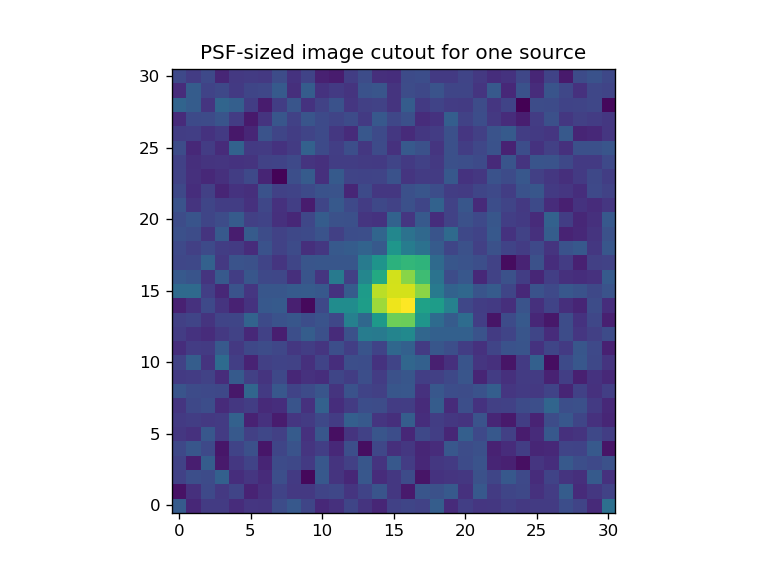

Text(0.5, 1.0, 'PSF-sized image cutout for one source')

In [8]:
# Source cutout of the calexp
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(res.cutExp.image.array, origin='bottom', interpolation='none')
ax.set_title("PSF-sized image cutout for one source")

In [9]:
# Test the minimization in this case
resD = minimizeDiff(res.cutExp, res.psfIm)

Residual image

<IPython.core.display.Javascript object>


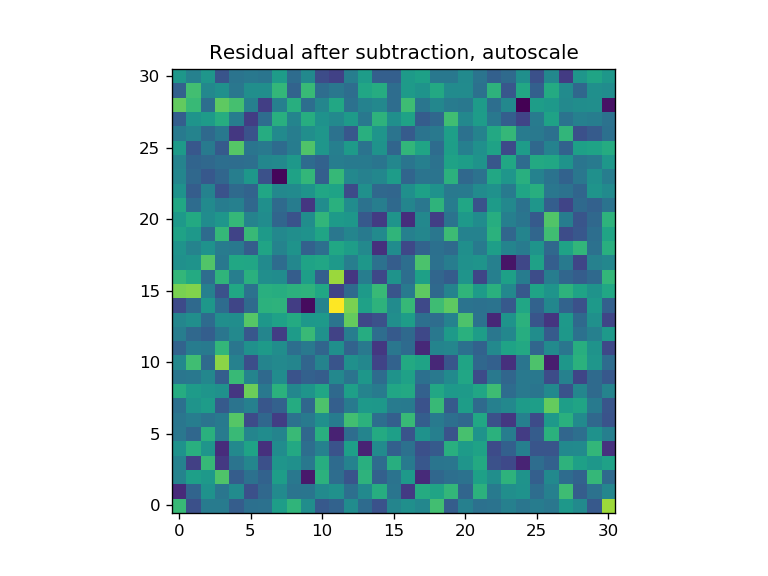

Text(0.5, 1.0, 'Residual after subtraction, autoscale')

In [10]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(resD.diffArr, origin='bottom', interpolation='none')
ax.set_title("Residual after subtraction, autoscale")

In [11]:
medianVar = np.median(calexp.variance.array)

-------

### Sanity check our minimization

If the two images are identical and differ only by a factor of 2 then the optimal solution
should be equal to 2.

In [12]:
%run -n -i "subtraction_defs.py"

In [13]:
im2 = res.cutExp.clone()
im2.image /= 2.
resD = minimizeDiff(res.cutExp, im2.image)

In [14]:
print(resD.x)

2.0000000000000018


-------

### Loop through good sources
Simple subtraction by optimizing the PSF multiplicative factor only

<IPython.core.display.Javascript object>


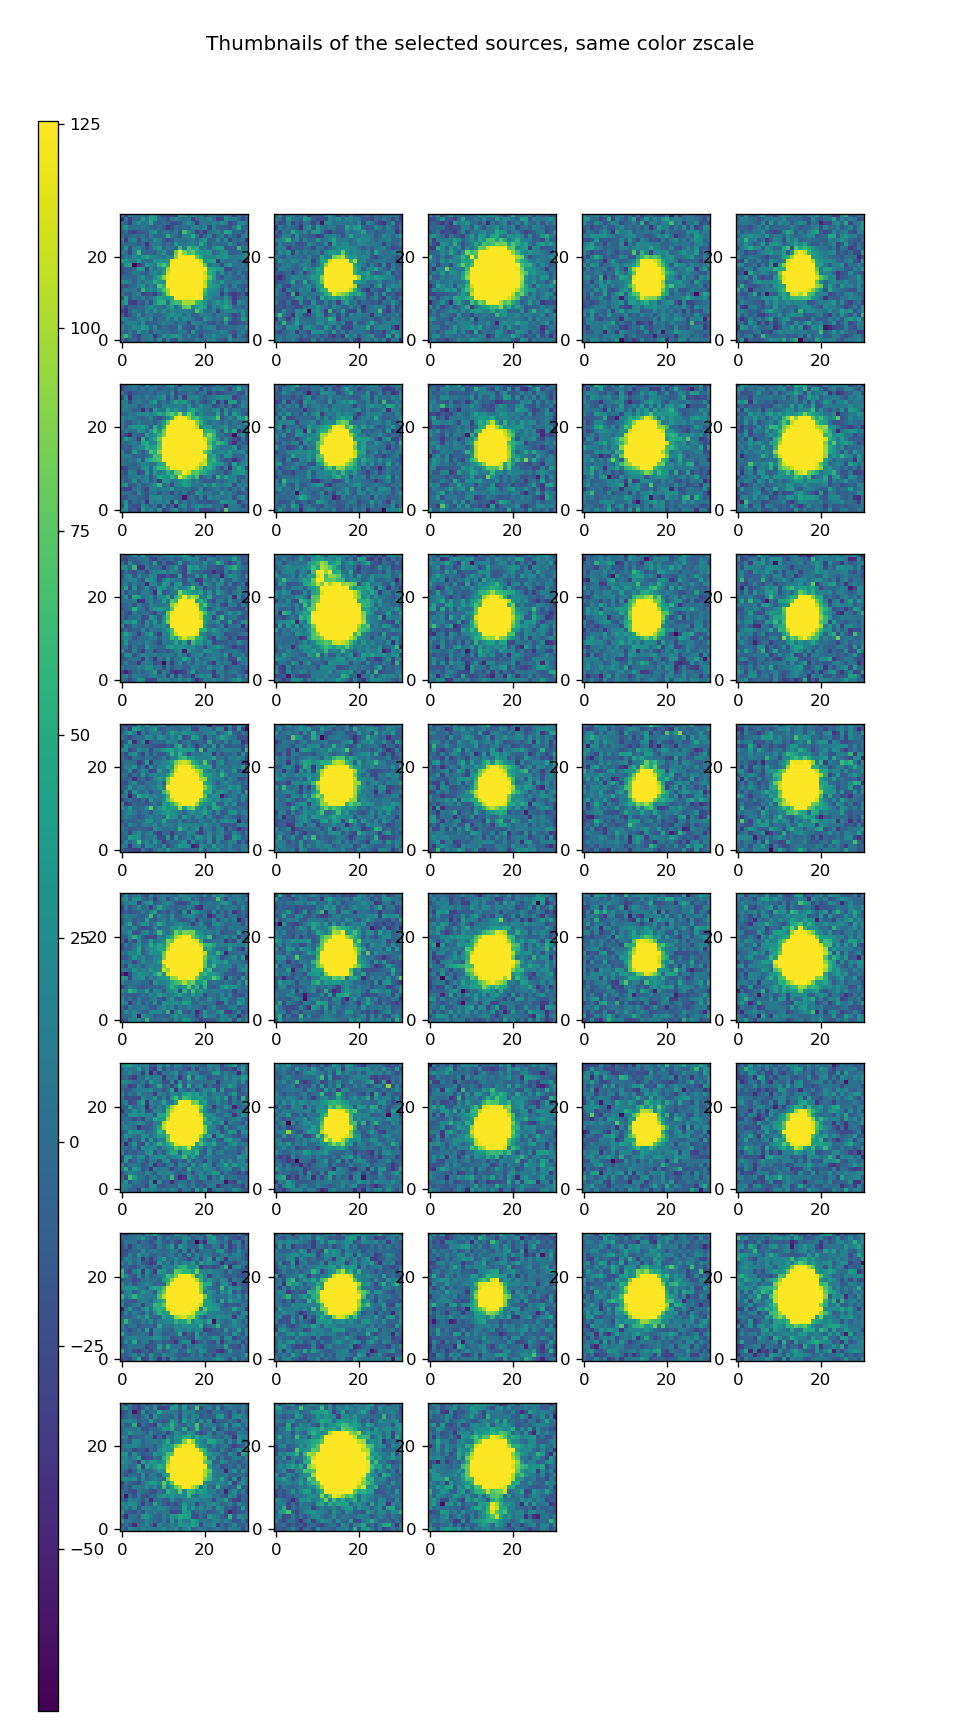

<IPython.core.display.Javascript object>


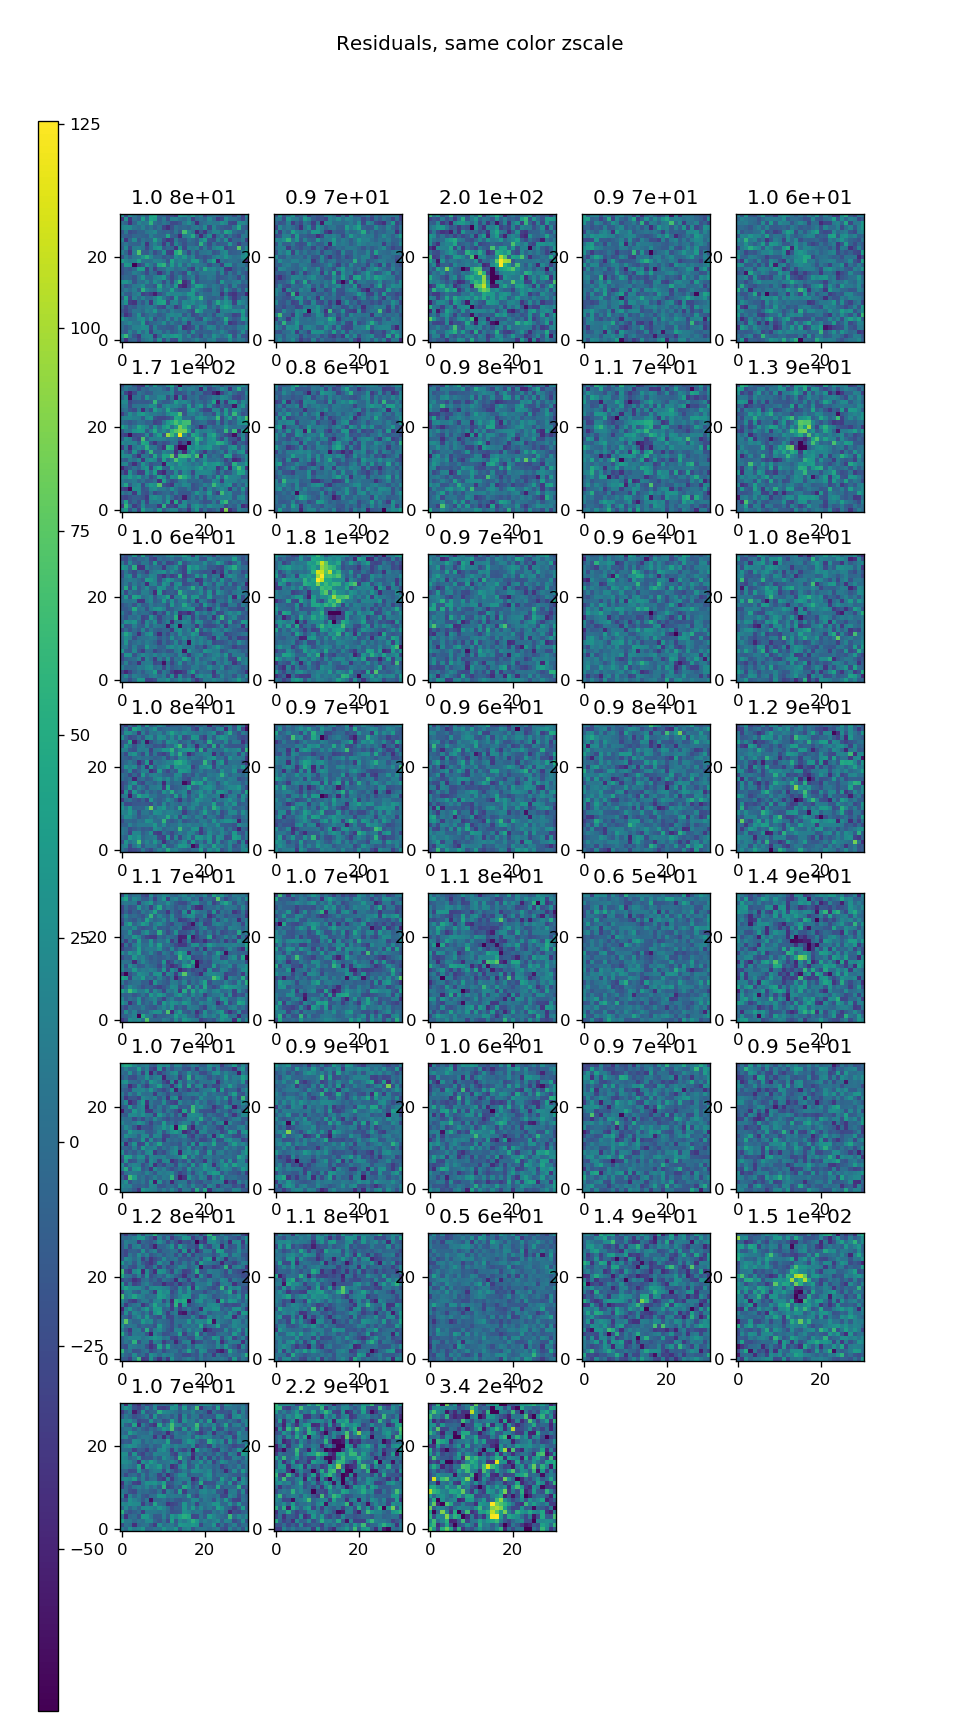

Text(0.5, 0.98, 'Residuals, same color zscale')

In [15]:
axPerRow = 5
nRows = len(i_goodSrc) // axPerRow + 1
fig_orig = plt.figure(figsize=(8, nRows*1.8))
fig = plt.figure(figsize=(8, nRows*1.8))

i_ax = 1
for i_src in i_goodSrc:
    i_src = int(i_src)  # numpy int is not compatible with pybind
    res = getCutoutAndPsf(calexp, srcCat[i_src])
    resD = minimizeDiff(res.cutExp, res.psfIm)
    chi2perDof = resD.chi2 / medianVar / resD.diffArr.size
    
    ax = fig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig = fig_orig.add_subplot(nRows, axPerRow, i_ax)
    ax_orig.imshow(res.cutExp.image.array, origin='bottom', interpolation='none', 
                   vmin=vmin, vmax=vmax)
    A = resD.diffArr
    cb = ax.imshow(A, origin='bottom', interpolation='none', vmin=vmin, vmax=vmax)
    
    ax.set_title(f"{chi2perDof:.1f} {np.max(A):.0e}")
    i_ax += 1
ax = fig.add_axes((0.04,0.01,0.02,0.92))
fig.colorbar(cb, cax=ax)
ax = fig_orig.add_axes((0.04,0.01,0.02,0.92))
fig_orig.colorbar(cb, cax=ax)
fig_orig.suptitle("Thumbnails of the selected sources, same color zscale")
fig.suptitle("Residuals, same color zscale")

Top-left: residual chi2 per pixel. Top-right: maximum value of residual image.

 * For sources with apparent additional secondary source in the cutout (e.g. 3rd row 2nd col; last one) the residual minimization results in oversubtraction. The negative residual of the primary source can be seen in the center and a positive residual of the satellite source. Also this is reflected by the higher chi2 per dof value.
 * Single sources are well subtracted, with chi2 per dof (pixel) around 1.0. This indicates that the median pixel noise was well reproduced on the residual. (The PSF image is noiseless.)


------